# OCR Final Pipeline

In [ ]:
#Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import required libraries
import cv2
%pip install imutils
import imutils
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Function to scan image
def scan_text(cnts, method="l2r"):
    #Select type like left to right, right to left, top to bottom, bottom to top
    reverse = False
    i = 0
    if method == "r2l" or method == "b2t":
        reverse = True
    if method == "t2b" or method == "b2t":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]             # Find the bounding box for each contour
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),   # Sort the contours and corresponding bounding boxes
    key=lambda b:b[1][i], reverse=reverse))                         # Reverse the order of the sorted contours bounding boxes
    return (cnts, boundingBoxes)                                    # Return the list of sorted contours and bounding boxes

In [ ]:
#Load the trained models  (Check CNN Training file to see how  CNN models are trained )
from keras.models import load_model
model = load_model('/content/drive/MyDrive/CS354/ocr-model.h5')    #Load model-1
model2 = load_model('/content/drive/MyDrive/CS354/ocr-model-2.h5') #Load model-2

In [ ]:
model.summary()  #Print model-1 summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [ ]:
#Define classes dictionary for the 2 models. 
#1st model has 36 classes and 2nd model has 35 classes

classes1 = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 
           9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 
           17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 
           25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 
           33: 'X', 34: 'Y', 35: 'Z'}

classes2 = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 
            9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 
            17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'P', 
            25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 
            33: 'Y', 34: 'Z'}



In [ ]:
#Function to segment words from the image
def get_words(img):
    image = cv2.imread(img)                                             #Read image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)                      #Convert to grayscale
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)    #Apply threshold
    dilated = cv2.dilate(thresh1, None, iterations=2)                   #Dilate the image

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)   #Find contours
    cnts = imutils.grab_contours(cnts)                                                   #Grab contours
    cnts = scan_text(cnts, method="l2r")[0]                                              #Scan the image from left to right 
    
    all_words = []                                                        #List to store all the words
    # loop over the contours
    for c in cnts: 
        if cv2.contourArea(c) > 10:                                                     #If contour area is greater than 10
            (x, y, w, h) = cv2.boundingRect(c)                                          #Get the coordinates of the bounding box
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)                #Draw the bounding box
        roi = gray[y:y + h, x:x + w]                                                    #Get the region of interest
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]  #Apply threshold
        all_words.append(thresh)                                                        #Append the word to the list
 
    return all_words, image                                                             #Return the list of words and the image with bounding boxes


In [ ]:
#Function to predict the characters in the image using VPP
def get_positions(vpp):
  ps = []         #ps stores beginning and end positions of all characters
  cur = [-1, -1]  #cur stores postions of current character
  
  for i in range(len(vpp)):
    if vpp[i] == 0:
      if cur != [-1, -1]:
        ps.append(cur)   #Add cur to ps
        cur = [-1, -1]   #Reset cur
    else:
      if cur[0] == -1:
        cur[0] = i      #Update character beginning position
      else:
        cur[1] = i      #Update character ending position
      
  if vpp[-1] != 0:
    ps.append(cur)  #Add cur to ps
  
  return ps

      


In [ ]:
def get_letters(words, model_num = 2):
  all_letters = []
  for w in words:
    vpp = np.sum(w, axis = 0)
    print(vpp)
    char_pos_list = get_positions(vpp)

    letters = []
    for char_pos in char_pos_list:
      char = w[:, char_pos[0]:char_pos[1]+1]
      thresh = cv2.resize(char, (32, 32), interpolation = cv2.INTER_CUBIC)
      plt.figure()
      plt.imshow(thresh)
      # print(thresh)
      thresh = thresh.astype("float32") / 255.0
      thresh = np.expand_dims(thresh, axis=-1)
      thresh = thresh.reshape(1,32,32,1)
      if model_num==1:
          [y_pred] = model.predict(thresh)
          y_pred = y_pred.argmax()
  #         print(y_pred)
          pred = classes1[y_pred]
          # print(pred, y_pred)
          letters.append(pred)
      else:
        [y_pred2] = model2.predict(thresh)
        y_pred2 = y_pred2.argmax()
#         print(y_pred)
        pred2 = classes2[y_pred2]
        # print(pred2, y_pred2)
        letters.append(pred2)
      # letters.append(thresh)

    all_letters.append("".join(letters))
  return all_letters


# Testing

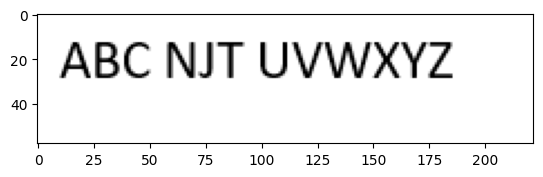

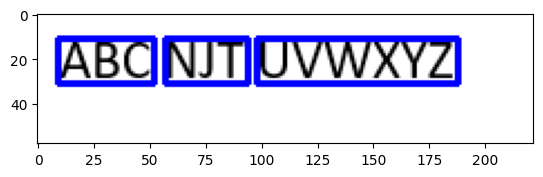

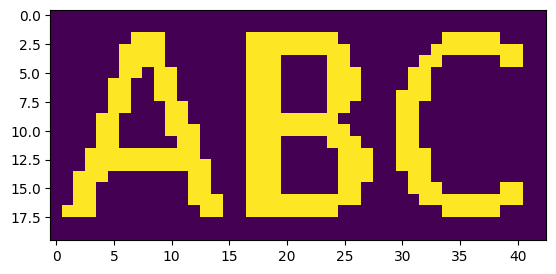

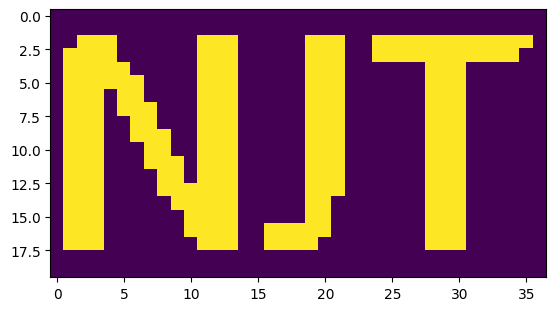

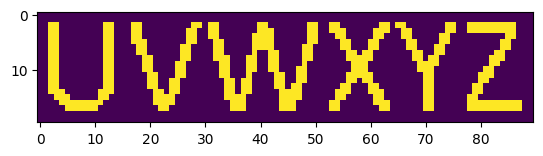

In [ ]:
path = "/content/drive/MyDrive/CS354/segment-3.png" #Path to image
im_orig = cv2.imread(path)                          #Read image
plt.figure()                                        #Plot image
plt.imshow(im_orig)                                 #Show image

words, image = get_words(path)                      #Get words from the image

plt.figure()                                        #Plot image with bounding boxes
plt.imshow(image)                                   #Show image
 
cnt = 1
for w in words:                                     #Loop over words
  plt.figure()                                      #Plot word  
  plt.imshow(w)                                     #Show word 
  cv2.imwrite(f'check-{cnt}.png', w)                #Save word
  cnt += 1                                          #Increment counter


[   0  255 1020 1530 1530 2040 2040 1530 1275 2040 2040 1530 1785 1275
  510    0    0 4080 4080 4080 1530 1530 1530 1530 3060 3315 2295  765
    0    0 1785 2805 2295 1020 1020 1020 1020 1020 1020 1020 1020    0
    0]
1/1 [==============================] - 0s 22ms/step
[   0 3825 4080 4080 1020 1020 1275 1275 1275 1020 1020 4080 4080 4080
    0    0  510  510  510 4080 3825 3060    0    0  510  510  510  510
 4080 4080 4080  510  510  510  510  255    0]
1/1 [==============================] - 0s 18ms/step
[   0    0 3315 3570  765  765  510  510  510  510  510  765 3570 3315
    0    0    0 1020 1530 1530 1530 1530 1020  765 1275 1530 1530 1530
 1020  255    0  765 1785 1785 2040 1530  765 1530 1785 1785 1275 1275
 2040 1785 1785 1020 1275 1530 1785 1785 1020    0    0 1020 1785 1785
 2040 1530 1020 1530 2040 2040 1785 1020    0  255  765 1020 1020 1020
 2295 2550 1020 1020 1020  510    0    0 1275 1785 2040 1785 2040 1785
 2040 1785 1275  510    0    0]
1/1 [========================

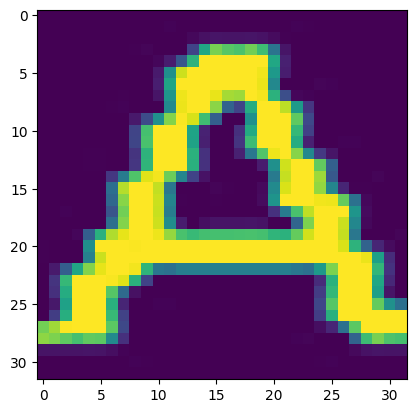

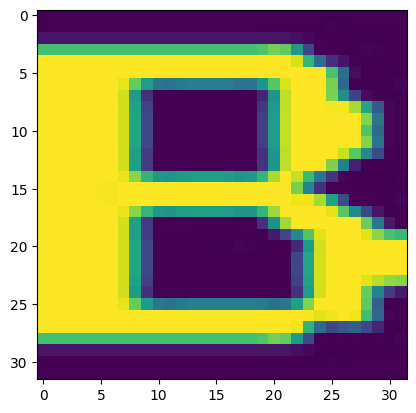

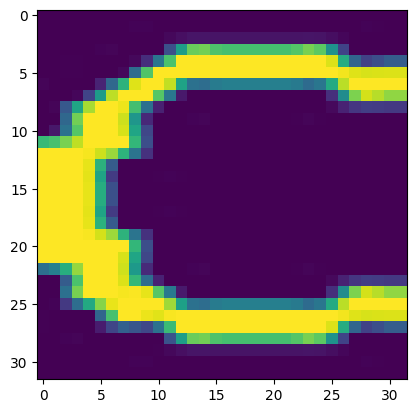

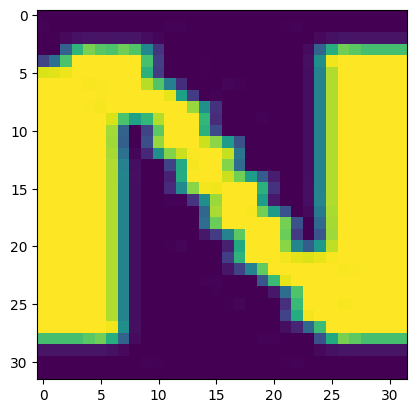

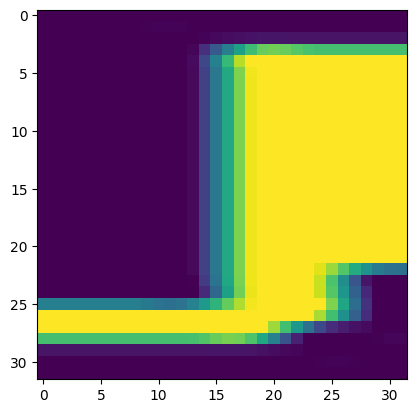

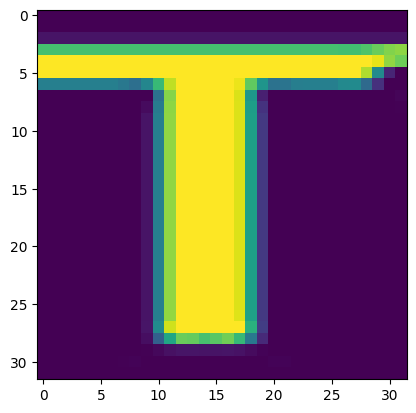

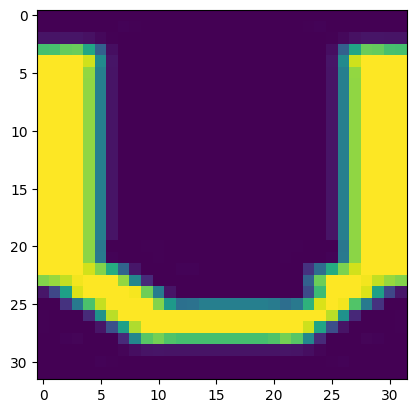

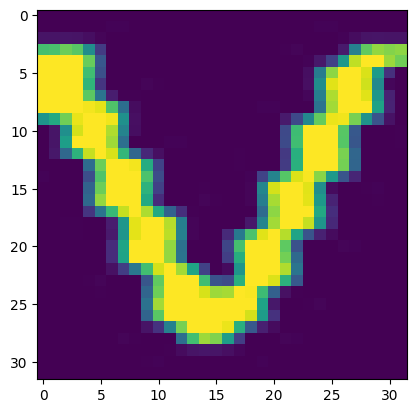

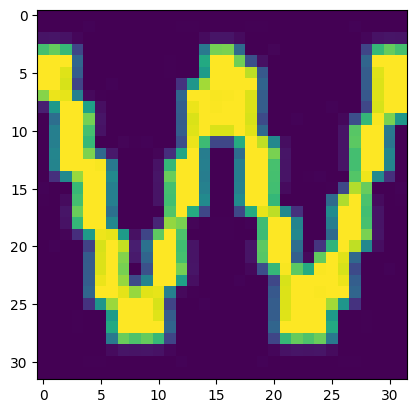

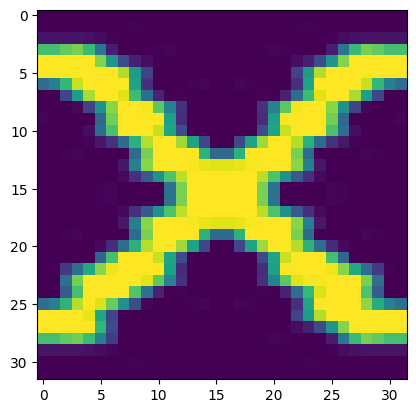

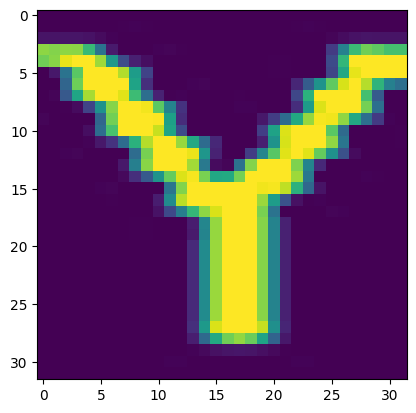

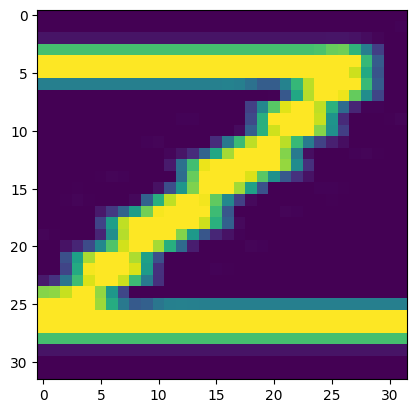

In [ ]:
all_letters = get_letters(words)   #Get letters from the words

In [ ]:
print(all_letters)   #Print the letters detected by OCR from the image

['ABC', 'NJI', 'LVWXYZ']
